# <span style='color:OrangeRed'>V10 - Kalman-Filter Demonstration</span>

In [26]:
from systheo2functions import *
%matplotlib inline

## Das verwendete Kalman-Filter:

<img src="bilder/v10_kalmanfilter.png"/>

### Ablauf in KalmanFilter([...],[...],N,M,F,G,C,Q,R,xo,Pk,Ts):

<div style="font-family: 'times'; font-size: 13pt; text-align: justify">
Zustandsvorhersage:<br>
x = F × x + G × u
<br><br>
Messvorhersage:<br>
z = C × x
<br><br>
Innovation:<br>
v = m - z
<br><br>
Kovarianz der Zustandsvorhersage:<br>
Pk = F × P × F.T + Q
<br><br>
Kovarianz der Innovation:<br>
S = C × Pk × C.T + R
<br><br>
Kalman Gain:<br>
Kk = Pk × C.T × inv(S)
<br><br>
Kovarianzkorrektur:<br>
Pk = (I - (Kk × C)) × Pk
<br><br>
Zustandskorrektur:<br>
x = x + (Kk × v)
<br><br>
Ausgabe des Zustandsvektors:<br>
Ausgabe = x

### Im Folgenden sind zwei Beispiele gegeben:

<div style="font-family: 'times'; font-size: 13pt; text-align: justify">
Beispiel 1 versucht das Kalman-Filter durch ein möglichst einfaches System zu erklären.<br>
Beispiel 2 versucht das Kalman-Filter an einem konkreten Problem zu erklären.

## <span style='color:Gray'>Beispiel #1 </span>

<div style="font-family: 'times'; font-size: 13pt; text-align: justify">
<img src="bilder/v10_regelstrecke.png"/><br>
Es ist zu sehen, dass ein Kalman-Filter verwendet wird, um das Messrauschen (w(k)) auszugleichen. Das Ziel ist es, dass die Ausgabe des Kalman-Filters, der Ausgabe des Systems ohne Messrauschen, möglichst nahe kommt.<br>
Das Messrauschen (w(k)) ist gaußverteilt (mit der Standartabweichung <code>sigma</code>) und wird auf die Ausgabe des Systems (y(k)) addiert.<br><br>
Das System erhält folgende Eigenschaften:
<p>A<small>d</small>=1, B<small>d</small>=1, C<small>d</small>=1, 
D<small>d</small>=0, x<small>0</small>=5
</p><br>
Daraus folgen einige Parameter für das Kalman-Filter:
<p><code>F</code>=A<small>d</small>=1<br> <code>G</code>=B<small>d</small>=1<br>
<code>xo</code>=x<small>0</small>=5 wäre optimal, aber wir gehen hier davon aus, dass uns der Anfangs-Zustand x<small>0</small>=5 nicht bekannt ist und  können daher <code>xo</code> frei einstellen.
</p><br>
<code>Q</code>,<code>R</code>und<code>Pk</code> können ebenfalls frei eingestellt werden und wirken sich auf das Verhalten des Filters aus.<br><br>
Während der Simulation wird die Ausgabe des Systems durch u(k) beeinflusst. u(k) ist auch unserem Kalman-Filter bekannt.

In [27]:
tini = 0 # Start time
tfinal = 6 # End time
dt = 0.01 # Time Step
nflows = 7 # Number of data flows in the schematic
Ts = 0.1 # Sampling time for discrete time


%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
fig.set_dpi(120)
ax.grid(True)

@widgets.interact(sigma=(0.1, 2, 0.1), u = ["on","off"], xo=(-10, 10, 1),
                  Q=[1, 0.1, 0.01, 0.001, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10],
                  R=(0.01, 1, 0.01), Pk=(0.01, 10, 0.01))

def update(sigma = 0.2, u="off", xo=3, Q=1e-9, R=0.2, Pk=1):
    """Remove old lines from plot and plot new one"""
    [l.remove() for l in ax.lines]
    [l.remove() for l in ax.lines]
    
    sc = Schema(tini,tfinal,dt,nflows) # Instance of the simulation schematic

    om = Ts
    F = np.array([[1]])
    G = np.array([[1]])
    C = np.array([[1]])
    Q = np.array([[Q]]) # höhere Werte => stärkere Reaktion auf einzelne Messergebnisse
    R = np.array([[R]]) # höhere Werte => geringere Berücksichtigung der Messung
    xo = np.array([xo])
    Pk = np.array([[Pk]]) # höhere Werte => geringere Berücksichtigung des Ausgangszustandes xo
    
    if u=="on":
        c1 = SquareSignal(1,0.0,0.1,0.3,0.8) #input
    else:
        c1 = Constant(1,0)
    c2 = DTStateSpace([1],[2],np.array([[1]]),np.array([[1]]),np.array([[1]]),np.array([[0]]),np.array([5]),0.1)
    #DTStateSpace(inp,out,Ad,Bd,Cd,Dd,xo)
    c3 = Noise(2,3,sigma) # Addierte Gauss-Verteilung mit Standartabweichung sigma, Noise(inp,out,sigma)
    c4 = KalmanFilter([1,3],[4],1,1,F,G,C,Q,R,xo,Pk,Ts) # Kalman-Filter
    
    sc.AddListComponents(np.array([c1,c2,c3,c4]));
    
    #Run the schematic and plot:
    out = sc.Run(np.array([1, 2, 3,4]))


    ax.plot(out[0,:],out[3,:],'lightblue',out[0,:],out[2,:],'blue',out[0,:],out[4,:],'green')
    ax.legend(['Sensor','System','Ausgabe Kalman-Filter'])
    plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(FloatSlider(value=0.2, description='sigma', max=2.0, min=0.1), Dropdown(description='u',…

## <span style='color:Gray'>Beispiel #2 </span>

<div style="font-family: 'times'; font-size: 13pt; text-align: justify">
Ein Roboter balanciert auf einem Surfbrett und die Wellen unter dem Brett bewegen sich mit einer uns unbekannten Funktion:

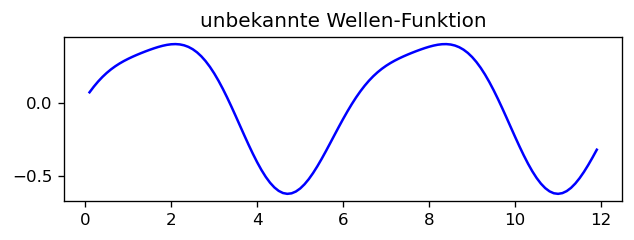

In [23]:
%matplotlib inline
scw = Schema(0,12,0.1,2) # Instance of the simulation schematic
w1 = UnknownWaveSource(1,0,0.5,1,0) # Wellen-Funktion
scw.AddListComponents(np.array([w1]));
outw = scw.Run(np.array([1]))

fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
fig.set_dpi(120)
ax.plot(outw[0,:],outw[1,:],'blue')
plt.title('unbekannte Wellen-Funktion')
plt.show()

<div style="font-family: 'times'; font-size: 13pt; text-align: justify">
<img src="bilder/v10_roboter.png"/><br>
Die Sensoren des Roboters erfassen den Verlauf der Wellen (b.z.w. die Höhe der Wellen), aber leider ist deren Ausgabe ungenau. <br><br>
Zusätzlich lässt sich der Verlauf der Wellen mathematisch nähern. So könnte man z.B. sagen, dass der Verlauf der Wellen sinus-ähnlich ist. Eine <b> mathematische Näherung entspricht nicht immer ganz der Wirklichkeit </b> und so ist die uns unbekannte Wellenfunktion keine Sinus-Funktion, aber wir hoffen, dass unsere Näherung später gut genug ist, damit sie (zusammen mit der Ausgabe der Sensoren und dem Kalman-Filter) zufriedenstellende Ergebnisse liefert.

<div style="font-family: 'times'; font-size: 13pt; text-align: justify">
Die Vorhersage/Näherung wird durch Matrizen und Vektoren ausgedrückt (in diesem Fall mit einer Drehmatrix und einem Vektor).<br><br>
Zustandsvorhersage: <code>x = F × x + G × u</code> mit <code>F</code> als Zustandsmatrix und <code>x</code> als Zustandsvektor. In diesem Beispiel ist <code>u</code> = 0 und somit ist <code>G × u</code> = 0.
<br><br>Durch <code>C × x</code> erhalten wir die Messvorhersage (hier <code>x[0]</code>). Die Messvorhersage ist das was wir von den Sensoren als Messung erwarten, also hier die momentane Höhe der Wellen.

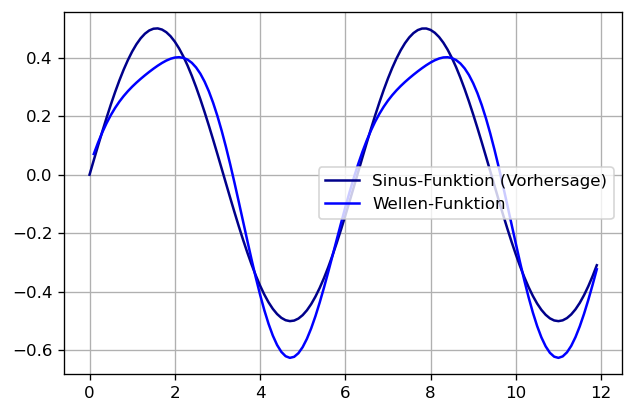

In [15]:
%matplotlib inline
om = 0.1

F = np.array([[cos(om),sin(om)],
              [-sin(om),cos(om)]])
x = np.array([0,0.5])

C=np.array([1,0])

y = [dot(C,x)]

# Zustandsvorhersage:
# x^ = F*x + G*u
# Hier mit G*u=0

# Messvorhersage:
# z = C*x^

for i in range(0,119):
    x = (dot(F,x)) # Zustandsvorhersage
    z = dot(C,x) # Messvorhersage (hier z = dot(C,x) = x[0])
    y.append(z)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
fig.set_dpi(120)
ax.plot(np.arange(0.0, 120*0.1, 0.1),y,'darkblue',outw[0,:],outw[1,:],'blue')
ax.grid()
ax.legend(['Sinus-Funktion (Vorhersage)','Wellen-Funktion'])
plt.show()

<div style="font-family: 'times'; font-size: 13pt; text-align: justify">
Das Kalman-Filter hilft uns nun unsere Vorhersage und die Ausgabe der Sensoren so zu kombinieren, dass der Verlauf der Wellen möglichst gut beschrieben werden kann, obwohl unser mathematisches Modell und die Sensoren des Roboters die Wirklichkeit nicht perfekt beschreiben. Wir übergeben unsere Vorhersage (<code>F</code>, <code>C</code> und <code>xo</code> als Anfangs-Zustand) an das Kalman-Filter, welches zusätzlich mit den Daten der Sensoren gefüttert wird.<br><br>
Andere Matrizen, die an das Kalman-Filter übergeben werden (<code>Q</code>,<code>R</code>und<code>Pk</code>), beeinflussen wie stark sich die mathematische Vorhersage und die Messung auf die Ausgabe des Filters auswirken.

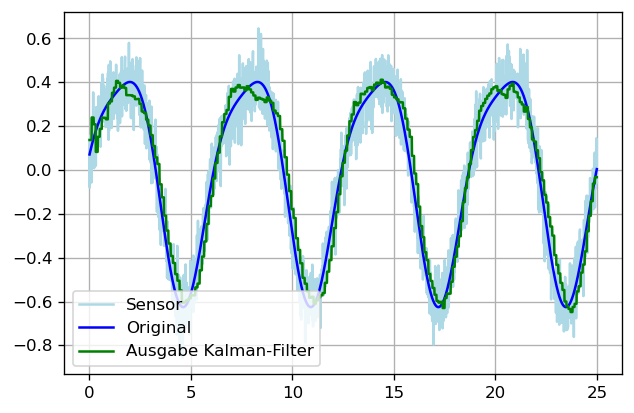

In [16]:
%matplotlib inline
tini = 0 # Start time
tfinal = 25 # End time
dt = 0.01 # Time Step
nflows = 7 # Number of data flows in the schematic
Ts = 0.1 # Sampling time for discrete time

sc = Schema(tini,tfinal,dt,nflows) # Instance of the simulation schematic

om = Ts
F = np.array([[cos(om),sin(om)],
              [-sin(om),cos(om)]])
G = np.array([[0,0],
              [0,0]])
C = np.array([[1,0],
              [0,0]]) # hier 2x2, aber erfüllt die gleiche Aufgabe wie C im oberen Code-Block
Q = np.array([[3.25e-06, 6.50e-05],
       [6.50e-05, 1.30e-03]]) # höhere Werte => stärkere Reaktion auf einzelne Messergebnisse
R = np.array([[0.01,0],
              [0,0.01]]) # höhere Werte => geringere Berücksichtigung der Messung
xo = np.array([0,0.5])
Pk = np.array([[100,0],
               [0,100]]) # höhere Werte => geringere Berücksichtigung des Ausgangszustandes xo

c1 = UnknownWaveSource(1,0,0.5,1,0) # Wellen-Funktion
c2 = Noise(1,2,0.08) # Ausgabe Sensor
c3 = KalmanFilter([2],[3],0,1,F,G,C,Q,R,xo,Pk,Ts) # Kalman-Filter



sc.AddListComponents(np.array([c1,c2,c3]));

#Run the schematic and plot:
out = sc.Run(np.array([1, 2, 3]))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
fig.set_dpi(120)
ax.plot(out[0,:],out[2,:],'lightblue',out[0,:],out[1,:],'blue',out[0,:],out[3,:],'green')
ax.grid()
ax.legend(['Sensor','Original','Ausgabe Kalman-Filter'])
plt.show()

<div style="font-family: 'times'; font-size: 13pt; text-align: justify">
Es ist zu sehen, dass das Kalman-Filter es schafft, aus unserer mathematischen Vorhersage und den Daten der Sensoren, eine Ausgabe zu erzeugen, welche den Verlauf der Wellen nahekommt. Dies kann nun genutzt werden, um den Roboter möglichst gut zu balancieren.